In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import itertools

To apply the strategy on unseen data, simply change the `stock` name and provide its corresponding CSV in the correct file path. No retraining is needed — all required functions for processing, strategy execution, and plotting are reusable as-is.

In [2]:
stock = 'NKE'
file_path = './'+ stock +'.csv'

# Strategy 1: RSI

In [3]:
# Function to compute RSI for a given series and window
def compute_RSI(series, window):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    RS = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to build the RSI strategy with long and short positions
def rsi_strategy(data, window, oversold=30, overbought=80):
    df = data.copy()
    df['RSI'] = compute_RSI(df['Close'], window)

    # Generate trading signals: +1 for long, -0.5 for short
    df['Signal'] = 0
    df['Signal'] = df['Signal'].astype(float)
    df.loc[df['RSI'] < oversold, 'Signal'] = 1  # Long
    df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)

    # Carry forward the last signal until a new signal appears
    df['pos'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)

    # Calculate daily returns and strategy returns
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['pos'].shift(1) * df['Returns']
    df['Strategy_Returns'].fillna(0, inplace=True)

    # Compute cumulative returns
    test_df = df.loc['2024-03-01':]
    test_df['Cumulative_Return_Strategy'] = (1 + test_df['Strategy_Returns']).cumprod()
    total_return = test_df['Cumulative_Return_Strategy'].iloc[-1]
    # test_df.to_csv('Predictions of ' + stock + '.csv')

    return total_return, test_df

# Function to perform grid search over RSI windows
def find_best_rsi_window(df, window_range):
    results = {}
    for window in window_range:
        total_return, _ = rsi_strategy(df, window)
        results[window] = total_return
    best_window = max(results, key=results.get)
    _, best_strategy_df = rsi_strategy(df, best_window)
    return best_window, results, best_strategy_df

In [4]:
def get_rsi_result(data):
    # Use your existing grid search functions
    window_range = range(5, 61, 3)
    best_window, results, best_strategy_df = find_best_rsi_window(data, window_range)
    # Calculate total (net) return: subtract 1 to get a percentage gain/loss
    total_return = best_strategy_df['Cumulative_Return_Strategy'].iloc[-1] - 1
    return best_strategy_df, best_window, total_return, results

In [5]:
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
df.dropna()

df_rsi, best_window, cum_ret_rsi, rsi_results = get_rsi_result(df)

# Strategy 2: Linear Regression

In [6]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    '''
    Generate lagged features for a specified column
    '''
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df

In [7]:
def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    
    # Here the target variables are the next day's values
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    
    df = df.dropna()
    df = scale_columns(df, 10)
    return df

def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    train_data = df.loc[:'2024-02-28'].copy()
    test_data = df.loc['2024-02-29':].copy()
    return (train_data[feature_cols], test_data[feature_cols], train_data[['Target', 'Target_Returns']] , test_data[['Target', 'Target_Returns']])

In [8]:
seed = 12345
data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
idx = data.loc['2024-03-01':].index
close_price = data.loc['2024-03-01':]['Close']

def fit_and_predict_models(stock, X_train, X_test, y_train, y_test, save_to=None, flag='linreg'):
    df_result = pd.DataFrame() if not save_to else save_to
    if flag == 'linreg':
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
    
    if flag == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=seed)
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = np.exp(benchmark_ret.cumsum())
    
    # As the target variables that we defined above are the next day's values, we need to revert it back
    df_result.index = idx
    # df_result.to_csv('Predictions of ' + stock + '.csv')
    return df_result

In [9]:
def strategy(file_path, flag):
    data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
    data = preprocess_data(data)
    data = data.drop(columns=['Stock Splits'])
    
    X_train, X_test, y_train, y_test = stock_train_test_split(data)
    df_result = fit_and_predict_models(stock=stock, X_train=X_train, X_test=X_test, 
                                       y_train=y_train, y_test=y_test, flag=flag)
    df_result['Close'] = close_price
    # Return the DataFrame (with index as dates and the key columns: 'pos' and 'Cumulative_Return_Strategy')
    return df_result

In [10]:
df_linreg = strategy(file_path, flag='linreg')

# Strategy 3: Random Forest

In [11]:
df_rf = strategy(file_path, flag='rf')

# Strategy 4: Logistic Regression

In [12]:
def calculate_moving_averages(data):
    sma10 = data['Close'].shift(1).rolling(window = 10).mean()
    sma50 = data['Close'].shift(1).rolling(window = 50).mean()
    ema20 = data['Close'].shift(1).ewm(span = 20, adjust = False).mean()
    return (sma10, sma50, ema20)

def calculate_bb(data):
    rolling_mean = data['Close'].shift(1).rolling(window = 20).mean()
    rolling_std = data['Close'].shift(1).rolling(window = 20).std()
    boll_upper = rolling_mean + (2 * rolling_std)
    boll_lower = rolling_mean - (2 * rolling_std)
    return (boll_upper, boll_lower)

def calculate_macd(data):
    macd = data['Close'].shift(1).ewm(span = 12, adjust = False).mean() - data['Close'].shift(1).ewm(span = 26, adjust = False).mean()
    macd_signal = macd.ewm(span = 9, adjust = False).mean()
    return (macd, macd_signal)

In [13]:
def momentum_oscillator(data):
    stoch_k = ((data['Close'].shift(1) - data['Low'].shift(1).rolling(window = 14).min()) /
                     (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * 100

    williams_R = ((data['High'].shift(1).rolling(window = 14).max() - data['Close'].shift(1)) /
                         (data['High'].shift(1).rolling(window = 14).max() - data['Low'].shift(1).rolling(window = 14).min())) * -100
    return (stoch_k, williams_R)

def volume_indicators(data):
    # On-balance Volume (OBV)
    obv = (np.sign(data['Close'].shift(1).diff()) * data['Volume'].shift(1)).fillna(0).cumsum()

    # VWAP (Volume Weighted Average Price)
    vwap = (data['Close'].shift(1) * data['Volume'].shift(1)).cumsum() / data['Volume'].shift(1).cumsum()
    return (obv, vwap)

def directional_movement(data):
    dm_plus = np.where((data['High'].shift(1) - data['High'].shift(2)) > (data['Low'].shift(2) - data['Low'].shift(1)), 
                             np.maximum(data['High'].shift(1) - data['High'].shift(2), 0), 0)
    dm_minus = np.where((data['Low'].shift(3) - data['Low'].shift(1)) > (data['High'].shift(1) - data['High'].shift(2)), 
                              np.maximum(data['Low'].shift(2) - data['Low'].shift(1), 0), 0)
    return (dm_plus, dm_minus)

In [14]:
def feature_selection(data):
    global stock  # Access global stock variable

    stock_config = {
        'NKE': {'top_k': 7, 'random_state': 42},
    }
    default_config = {'top_k': 9, 'random_state': 2}
    config = stock_config.get(stock, default_config)

    features = data.columns[7:]
    train_data = data[data.index < '2024-03-01'].copy()
    X = train_data[features]
    y = train_data['direction']

    # Mutual Information
    mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=config['random_state'])
    mi_selected = pd.Series(mi_scores, index=features).nlargest(config['top_k']).index.tolist()

    # RFE
    rf = RandomForestClassifier(n_estimators=100, random_state=config['random_state'])
    rfe = RFE(rf, n_features_to_select=config['top_k'])
    rfe.fit(X, y)
    rfe_selected = X.columns[rfe.support_].tolist()

    return list(set(mi_selected) | set(rfe_selected))

In [15]:
def strategy_logreg(stock, train_data, test_data):    
    start_date = '2021-03-01'
    end_date = '2024-01-21'
    df1 = yf.download(stock, start=start_date, end=end_date)
    df1 = df1.droplevel(1, axis=1)
    df2 = train_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    df3 = test_data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()
    
    # Combine all data
    df = pd.concat((df1, df2, df3))
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['direction'] = (df['Returns'] > 0).astype(int)
    df['direction'] = np.where(df['direction'] == 0, -1, df['direction'])
    df.dropna(inplace=True)
    
    df['SMA_10'], df['SMA_50'], df['EMA_20'] = calculate_moving_averages(df)
    df['boll_upper'], df['boll_lower'] = calculate_bb(df)
    df['MACD'], df['MACD_signal'] = calculate_macd(df)
    df['stoch_k'], df['williams_R'] = momentum_oscillator(df)
    df['OBV'], df['VWAP'] = volume_indicators(df)
    
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)
        
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df.dropna(inplace=True)
    
    final_selected_features = feature_selection(df)
    scaler = StandardScaler()
    df[final_selected_features] = scaler.fit_transform(df[final_selected_features])
    
    train_data_new = df.loc[:'2024-02-29'].copy()
    test_data_new = df.loc['2024-03-01':].copy()
    
    X_train, y_train = train_data_new[final_selected_features], train_data_new['direction']
    X_test, y_test = test_data_new[final_selected_features], test_data_new['direction']
    
    # Train Models
    if stock == 'CAT':
        model = LogisticRegression(solver='lbfgs', C=0.7, random_state=12345)
        model.fit(X_train, y_train)
        
    elif stock == 'NKE': #sag 0.5
        model = LogisticRegression(solver='liblinear', C=0.6, random_state=12345)
        model.fit(X_train, y_train)
        
    else:
        model = LogisticRegression(solver='lbfgs', C=0.6, random_state=12345)
        model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    test_data_new['pos'] = np.where(predictions < 0, -0.5, 1)
    test_data_new['strategy_returns'] = test_data_new['pos'] * test_data_new['Returns']
    test_data_new['Cumulative_Return_Strategy'] = test_data_new['strategy_returns'].cumsum().apply(np.exp)
    
    # Calculate cumulative (gross) return (subtract 1 if you prefer net return)
    cumulative_return = np.exp(test_data_new['strategy_returns'].sum()) - 1
    return test_data_new, cumulative_return

In [16]:
src = pd.read_csv(file_path, parse_dates = True, index_col = 0) 
df_logreg, cum_ret_logreg = strategy_logreg(stock, src.loc[:'2024-02-29'], src.loc['2024-03-01':])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Strategy 5: MLP

In [17]:
def select_feature(X_train, y_train):
    # 1. Mutual Information (MI)
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=False,random_state=42)
    mi_selected = pd.Series(mi_scores, index=X_train.columns).nlargest(3).index.tolist()
    
    # 2. Recursive Feature Elimination (RFE) with RandomForest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(rf, n_features_to_select=3)
    rfe.fit(X_train, y_train)
    rfe_selected = X_train.columns[rfe.support_].tolist()
    
    # Select Top Features (Union of All Methods)
    selected_features = list(set(mi_selected + rfe_selected))
    return selected_features

In [18]:
def strategy_monthly(stock, data_train, data_test):
    start_date = '2021-01-01'
    end_date = '2024-01-21'
    df1 = yf.download(stock, start=start_date, end=end_date)
    df1 = df1.droplevel(1, axis=1)
    df2 = data_train[['Close', 'High', 'Open', 'Low', 'Volume']].copy()
    df3 = data_test[['Close', 'High', 'Open', 'Low', 'Volume']].copy()
    
    df = pd.concat([df1, df2, df3])
    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['direction'] = np.where(df['Returns'] > 0, 1, 0)
    ma = calculate_moving_averages(df)
    df['SMA_10'] = ma[0]
    df['EMA_20'] = ma[2]
    df['boll_upper'], df['boll_lower'] = calculate_bb(df)
    df['MACD'], df['MACD_signal'] = calculate_macd(df)
    df['OBV'] = volume_indicators(df)[0]
    df['williams_R'] = momentum_oscillator(df)[1]
    df['DM_plus'], df['DM_minus'] = directional_movement(df)
    df['Lag_Close'] = df['Close'].shift(1)
    df['Lag_Volume'] = df['Volume'].shift(1)
    for lag in range(1, 6):
        df[f'lag_{lag}'] = df['Returns'].shift(lag)
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df.dropna(inplace=True)
    
    all_features = df.columns[7:]
    scaler = StandardScaler()
    df[all_features] = scaler.fit_transform(df[all_features])
    
    df_train = df[df.index < '2024-03-01'].copy()
    df_test = df[df.index >= '2024-03-01'].copy()
    
    all_predictions = []
    current_start = pd.to_datetime('2024-03-01')
    
    while current_start <= df_test.index[-1]:
        current_end = (current_start + pd.DateOffset(months=1)).replace(day=1)
        current_test = df_test[(df_test.index >= current_start) & (df_test.index < current_end)]
        if current_test.empty:
            break
        X_train = df_train[all_features]
        y_train = df_train['direction']
        selected_features = select_feature(X_train, y_train)
        model = MLPClassifier(hidden_layer_sizes=(100, 70, 70), activation='logistic',
                              max_iter=1000, random_state=12345)
        model.fit(X_train[selected_features], y_train)
        X_test = current_test[selected_features]
        preds = model.predict(X_test)
        pos = np.where(preds == 0, -0.5, 1)
        all_predictions.extend(pos)
        df_train = pd.concat([df_train, current_test])
        current_start = current_end
        
    # Ensure df_test and predictions have the same length
    df_test = df_test.iloc[:len(all_predictions)].copy()
    df_test['pos'] = all_predictions
    df_test['returns_strat'] = df_test['pos'] * df_test['Returns']
    df_test['Cumulative_Return_Strategy'] = df_test['returns_strat'].cumsum().apply(np.exp)
    cumulative_return = np.exp(df_test['returns_strat'].sum()) - 1
    return df_test, cumulative_return

In [19]:
src = pd.read_csv(file_path, parse_dates = True, index_col = 0) 
df_mlp, cum_ret_mlp = strategy_monthly(stock, src.loc[:'2024-02-29'], src.loc['2024-03-01':])

[*********************100%***********************]  1 of 1 completed


# Combined Plot

In [20]:
def summarize_and_plot_returns(df_rsi, df_linreg, df_rf, df_logreg, df_mlp):
    # Final cumulative returns
    rsi = df_rsi['Cumulative_Return_Strategy'].iloc[-1]
    linreg = df_linreg['Cumulative_Return_Strategy'].iloc[-1]
    rf = df_rf['Cumulative_Return_Strategy'].iloc[-1]
    logreg = df_logreg['Cumulative_Return_Strategy'].iloc[-1]
    mlp = df_mlp['Cumulative_Return_Strategy'].iloc[-1]
    buy_hold = df_rsi['Close'].iloc[-1] / df_rsi['Close'].iloc[0]

    print('Cumulative Returns (Gross Multiplier and Net Return):')
    print(f'RSI Strategy:             {rsi:.4f} ({(rsi - 1):.2%})')
    print(f'Linear Regression:        {linreg:.4f} ({(linreg - 1):.2%})')
    print(f'Random Forest:            {rf:.4f} ({(rf - 1):.2%})')
    print(f'Logistic Regression:      {logreg:.4f} ({(logreg - 1):.2%})')
    print(f'MLP:                      {mlp:.4f} ({(mlp - 1):.2%})')
    print(f'Buy & Hold (Benchmark):   {buy_hold:.4f} ({(buy_hold - 1):.2%})')

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_rsi.index, df_rsi['Cumulative_Return_Strategy'], label='RSI')
    plt.plot(df_linreg.index, df_linreg['Cumulative_Return_Strategy'], label='Linear Regression')
    plt.plot(df_rf.index, df_rf['Cumulative_Return_Strategy'], label='Random Forest')
    plt.plot(df_logreg.index, df_logreg['Cumulative_Return_Strategy'], label='Logistic Regression')
    plt.plot(df_mlp.index, df_mlp['Cumulative_Return_Strategy'], label='MLP')
    benchmark_series = df_rsi['Close'] / df_rsi['Close'].iloc[0]
    plt.plot(df_rsi.index, benchmark_series, label='Buy & Hold (Benchmark)', color='dimgray')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the returns for later use
    return {
        'RSI': rsi,
        'Linear Regression': linreg,
        'Random Forest': rf,
        'Logistic Regression': logreg,
        'MLP': mlp
    }

Cumulative Returns (Gross Multiplier and Net Return):
RSI Strategy:             1.2224 (22.24%)
Linear Regression:        1.0575 (5.75%)
Random Forest:            1.1180 (11.80%)
Logistic Regression:      1.2533 (25.33%)
MLP:                      1.1619 (16.19%)
Buy & Hold (Benchmark):   0.7074 (-29.26%)


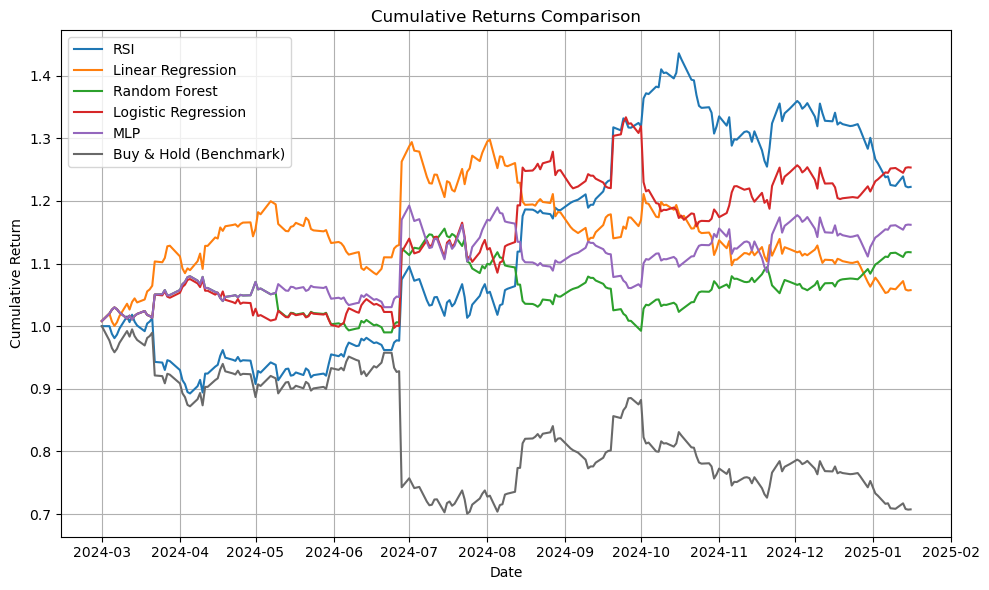

In [21]:
strategy_returns = summarize_and_plot_returns(df_rsi, df_linreg, df_rf, df_logreg, df_mlp)

In [22]:
def plot_best_strategy_position(strategy_returns, df_dict):
    best_name = max(strategy_returns, key=strategy_returns.get)
    best_df = df_dict[best_name]
    print(f'\nBest Trading Strategy: {best_name} with cumulative return {strategy_returns[best_name]:.4f} ({(strategy_returns[best_name] - 1):.2%})')

    # --- Plot Position vs Stock Price
    plt.figure(figsize=(10, 6))
    plt.plot(best_df.index, best_df['pos'], label=f'{best_name} Position', color='red', linewidth=2)
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(best_df.index, best_df['Close'], label='Stock Price', color='black', alpha=0.8)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Position')
    ax2.set_ylabel('Stock Price')
    plt.title(f'Trading Positions for Best Strategy: {best_name}')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Cumulative Return vs Benchmark
    plt.figure(figsize=(10, 5))
    plt.plot(best_df.index, best_df['Cumulative_Return_Strategy'], label=f'{best_name} Strategy')
    benchmark_series = best_df['Close'] / best_df['Close'].iloc[0]
    plt.plot(best_df.index, benchmark_series, label='Buy & Hold (Benchmark)')
    plt.title(f'Cumulative Return: {best_name} vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print Final Returns
    strat_return = best_df['Cumulative_Return_Strategy'].iloc[-1]
    bench_return = benchmark_series.iloc[-1]
    print(f'\nFinal Cumulative Return of {best_name}: {strat_return:.4f} ({(strat_return - 1):.2%})')
    print(f'Final Cumulative Return of Benchmark: {bench_return:.4f} ({(bench_return - 1):.2%})')

    return best_name, best_df


Best Trading Strategy: Logistic Regression with cumulative return 1.2533 (25.33%)


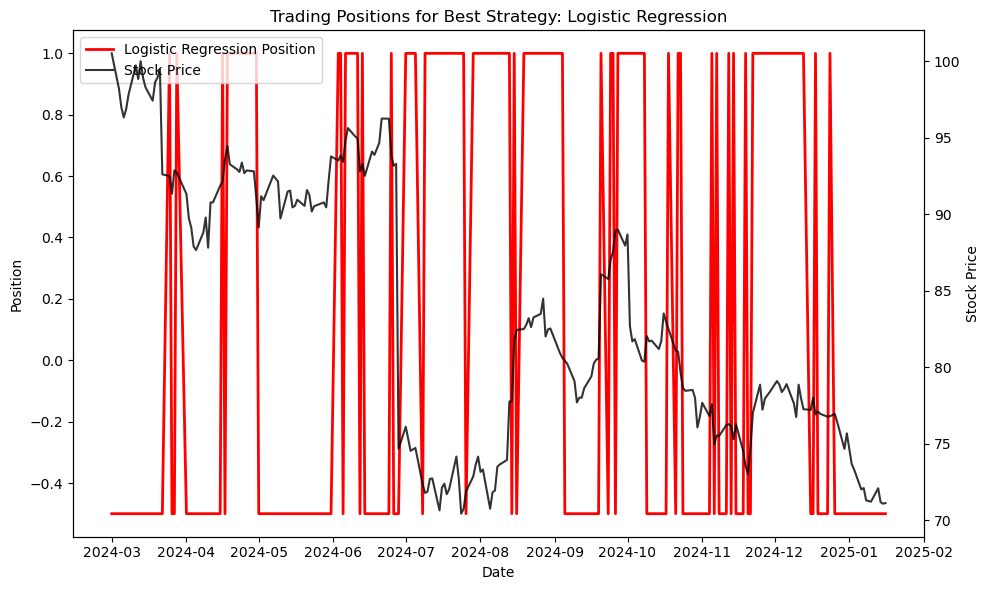

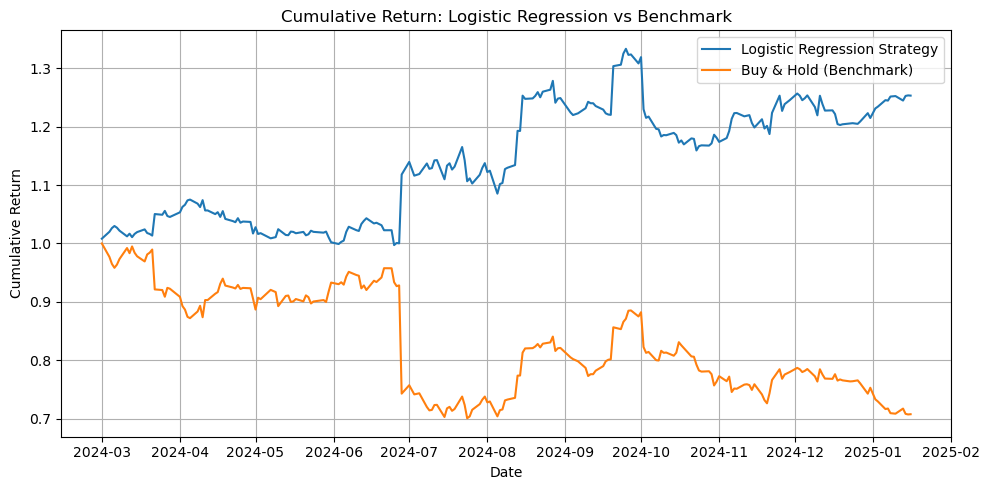


Final Cumulative Return of Logistic Regression: 1.2533 (25.33%)
Final Cumulative Return of Benchmark: 0.7074 (-29.26%)


In [23]:
df_dict = {
    'RSI': df_rsi,
    'Linear Regression': df_linreg,
    'Random Forest': df_rf,
    'Logistic Regression': df_logreg,
    'MLP': df_mlp
}
best_strategy_name, best_df = plot_best_strategy_position(strategy_returns, df_dict)

In [24]:
def generate_trade_log(best_df):
    trade_table = best_df[['pos', 'Cumulative_Return_Strategy']].copy()
    trade_table['Trade Signal'] = best_df['pos'].where(best_df['pos'].diff() != 0)
    trade_table = trade_table.dropna(subset=['Trade Signal'])
    trade_table = trade_table.rename(columns={'Cumulative_Return_Strategy': 'Cumulative Return'})
    trade_table = trade_table[['Trade Signal', 'Cumulative Return']]
    trade_table.index.name = 'Date'

    final_date = best_df.index[-1]
    if final_date not in trade_table.index:
        final_row = pd.DataFrame({
            'Trade Signal': [best_df['pos'].iloc[-1]],
            'Cumulative Return': [best_df['Cumulative_Return_Strategy'].iloc[-1]]
        }, index=[final_date])
        final_row.index.name = 'Date'
        trade_table = pd.concat([trade_table, final_row])

    trade_table = trade_table.sort_index()
    print('Trade Logs:')
    display(trade_table)

    return trade_table

In [25]:
trade_table = generate_trade_log(best_df)

Trade Logs:


,Trade Signal,Cumulative Return
Date,,
2024-03-01,-0.5,1.008211
2024-03-25,1.0,1.049171
2024-03-26,-0.5,1.055780
2024-03-28,1.0,1.045383
2024-04-01,-0.5,1.053371
2024-04-16,1.0,1.053584
2024-04-17,-0.5,1.045498
2024-04-18,1.0,1.055420
2024-05-01,-0.5,1.027808


In [26]:
best_df.to_csv(f"Predictions of {stock}.csv")